In [1]:
import os 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


In [2]:
data = pd.read_csv("/kaggle/input/confused-eeg/EEG_data.csv")
data.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


<Axes: >

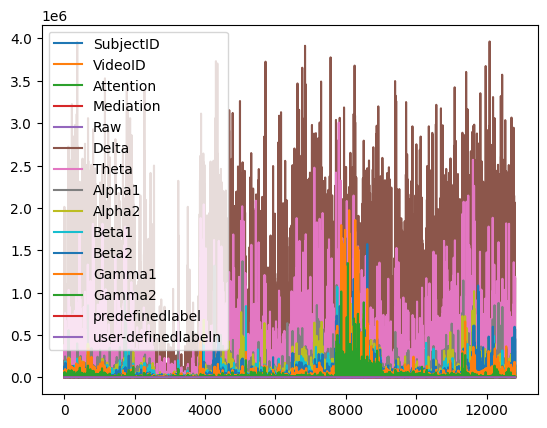

In [3]:
data.plot()

In [4]:
df = pd.DataFrame(data)

In [5]:
df.columns

Index(['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta',
       'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
       'predefinedlabel', 'user-definedlabeln'],
      dtype='object')

Segmentation:

In [6]:
#params for segmentation:
frequency = 2.0 #samples/sec (as sampled every 0.5s)
window_secs = 5 #window length we will use for segmentation
step_secs = 2.5 #step between windows, as window length = 5, 
#there will be a 50% overlap between windows

#rows per window/step:
window_rows = int(round(window_secs*frequency)) 
step_rows = int(round(step_secs*frequency)) 

X_raw, y, groups, meta = [], [], [], []

for (subject, video), trial in df.groupby(['SubjectID', 'VideoID'], sort = False):
    x = trial["Raw"].to_numpy(float)
    if len(x) < window_rows:
        continue #check if trial is long enough to make a full window

    label = int(trial["predefinedlabel"].iloc[0])
    for start in range(0, len(x) - window_rows + 1, step_rows):
        w = x[start:start + window_rows]   # one window vector (5s -> 10 samples)
        X_raw.append(w)
        y.append(label)
        groups.append(subject)
        meta.append({
            "subject": subject, "video": video,
            "start_idx": start,
            "start_time_s": start / frequency,
            "end_time_s": (start + window_rows) / frequency
        })
X_raw  = np.stack(X_raw, axis=0) if X_raw else np.empty((0, window_rows))
y = np.array(y, dtype=int)
groups = np.array(groups)
meta = pd.DataFrame(meta)

In [7]:
print("X_raw:", X_raw.shape)          # (N_windows, window_rows)
print("y:", y.shape, "unique subjects:", np.unique(groups).size)
print(meta.head())

X_raw: (2420, 10)
y: (2420,) unique subjects: 10
   subject  video  start_idx  start_time_s  end_time_s
0      0.0    0.0          0           0.0         5.0
1      0.0    0.0          5           2.5         7.5
2      0.0    0.0         10           5.0        10.0
3      0.0    0.0         15           7.5        12.5
4      0.0    0.0         20          10.0        15.0


In [8]:
#standardize windows:
mu = X_raw.mean(axis=1, keepdims=True)
sd = X_raw.std(axis=1, keepdims=True) + 1e-8
X_raw_z = (X_raw - mu) / sd

In [9]:
#set randomness for pytorch and numpy
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [10]:
#convert np arays to tensors:
X_t = torch.from_numpy(X_raw_z).float().unsqueeze(1)   
y_t = torch.from_numpy(y).long()                       
ds  = TensorDataset(X_t, y_t)

In [11]:
class CNN1D(nn.Module):
    def __init__(self, in_ch=1, n_classes=2, p_drop=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(64, n_classes)
        )
    def forward(self, x): 
        return self.net(x)

In [12]:
#training hyperparams:
EPOCHS = 15
BATCH = 64
LR = 1e-3
WD = 1e-4       # weight decay (L2)
P_DROP = 0.2

In [13]:
#Subject Aware splitting (Group K fold):
n_splits = min(5, np.unique(groups).size)
gkf = GroupKFold(n_splits=n_splits)

fold_accuracies, fold_f1_scores = [], []
for fold_idx, (train_indices, test_indices) in enumerate(
        gkf.split(X_raw_z, y, groups=groups), start=1):
    print(f"\n=== Fold {fold_idx}/{n_splits} ===")
    
    train_loader = DataLoader(Subset(ds, train_indices), batch_size=BATCH, shuffle=True)
    test_loader = DataLoader(Subset(ds, test_indices),  batch_size=BATCH*2, shuffle=False)

    model = CNN1D(p_drop=P_DROP)

    # Class-weighted loss on training set
    class_counts = np.bincount(y[train_indices], minlength=2)
    class_weights = (class_counts.sum() / np.maximum(class_counts, 1)).astype(np.float32)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

    #Training:
    for epoch in range(1, EPOCHS + 1):
            model.train()
            epoch_loss_sum = 0.0
            for xb, yb in train_loader:
                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()
                epoch_loss_sum += loss.item() * xb.size(0)
                
    #Eval on fold
    model.eval()
    test_preds, test_trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            test_preds.append(model(xb).argmax(1))
            test_trues.append(yb)
    y_pred = torch.cat(test_preds).numpy()
    y_true = torch.cat(test_trues).numpy()

    fold_accuracy = accuracy_score(y_true, y_pred)
    fold_f1 = f1_score(y_true, y_pred)
    fold_conf_matrix = confusion_matrix(y_true, y_pred)

    print("Fold results  acc", round(fold_accuracy,3), "f1", round(fold_f1,3), "\nCM:\n", fold_conf_matrix)
    print(classification_report(y_true, y_pred, digits=3))

    fold_accuracies.append(fold_accuracy)
    fold_f1_scores.append(fold_f1)

acc_mean = float(np.mean(fold_accuracies)); acc_std = float(np.std(fold_accuracies))
f1_mean  = float(np.mean(fold_f1_scores));  f1_std  = float(np.std(fold_f1_scores))


#Summary accross folds:
print("\n=== CNN1D GroupKFold summary ===")
print("Accuracies per fold:", [round(a,3) for a in fold_accuracies])
print(f"Mean accuracy: {acc_mean:.3f} ± {acc_std:.3f}")
print("F1 per fold:", [round(f,3) for f in fold_f1_scores])
print(f"Mean F1: {f1_mean:.3f} ± {f1_std:.3f}")


=== Fold 1/5 ===
Fold results  acc 0.512 f1 0.523 
CM:
 [[119 137]
 [100 130]]
              precision    recall  f1-score   support

           0      0.543     0.465     0.501       256
           1      0.487     0.565     0.523       230

    accuracy                          0.512       486
   macro avg      0.515     0.515     0.512       486
weighted avg      0.517     0.512     0.512       486


=== Fold 2/5 ===
Fold results  acc 0.49 f1 0.543 
CM:
 [[ 90 162]
 [ 85 147]]
              precision    recall  f1-score   support

           0      0.514     0.357     0.422       252
           1      0.476     0.634     0.543       232

    accuracy                          0.490       484
   macro avg      0.495     0.495     0.482       484
weighted avg      0.496     0.490     0.480       484


=== Fold 3/5 ===
Fold results  acc 0.491 f1 0.369 
CM:
 [[165  87]
 [159  72]]
              precision    recall  f1-score   support

           0      0.509     0.655     0.573       25